[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eyaler/workshop/blob/master/nn_8_attention.ipynb)

# Attention on VGGNet (Saliency and grad-CAM)

## Saliency

To visualize activation over final dense layer outputs, we need to switch the `softmax` activation out for `linear` since gradient of output node will depend on all the other node activations. Doing this in keras is tricky, so we provide `utils.apply_modifications` to modify network parameters and rebuild the graph.

If this swapping is not done, the results might be suboptimal. We will start by swapping out 'softmax' for 'linear'.

In [1]:
# update keras-vis to master
!pip install -U git+git://github.com/raghakot/keras-vis.git

  Cloning git://github.com/raghakot/keras-vis.git to /tmp/pip-req-build-u_dxt581
  Running command git clone -q git://github.com/raghakot/keras-vis.git /tmp/pip-req-build-u_dxt581
  Created wheel for keras-vis: filename=keras_vis-0.5.0-py2.py3-none-any.whl size=38885 sha256=c8d79a2dae61f44c07a541b36fa3c039609900cb08a2fd2c140bb05b68ec5502
  Stored in directory: /tmp/pip-ephem-wheel-cache-17d03d7t/wheels/ff/01/8e/3a66d951f9b53f9894a010107b05253fb9a6c6f2555a5aaeca
Successfully built keras-vis
  Found existing installation: keras-vis 0.4.1
    Uninstalling keras-vis-0.4.1:
      Successfully uninstalled keras-vis-0.4.1


In [2]:
from keras.applications import VGG16
from vis.utils import utils
from keras import activations
import numpy as np

# Build the VGG16 network with ImageNet weights
model = VGG16(weights='imagenet', include_top=True)

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'predictions')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

Using TensorFlow backend.
W0818 22:11:49.778058 140215800895360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0818 22:11:49.819184 140215800895360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0818 22:11:49.832954 140215800895360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0818 22:11:49.878900 140215800895360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



553467904/553467096 [==============================] - 13s 0us/step


W0818 22:12:04.388320 140215800895360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0818 22:12:04.389956 140215800895360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Lets load a couple of test images to try saliency.

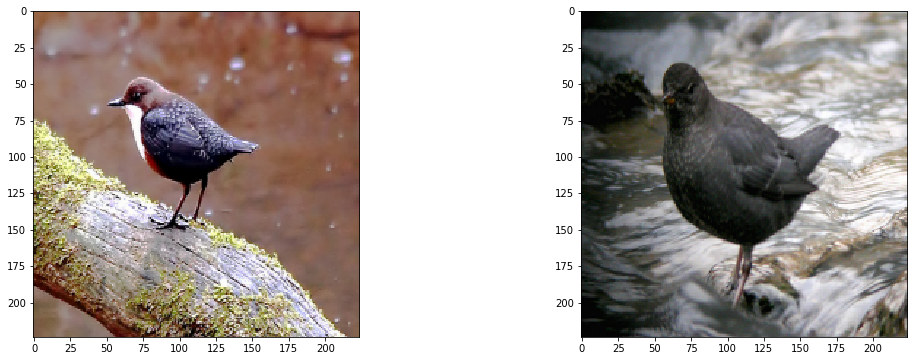

In [3]:
from vis.utils import utils
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

img1 = 'https://raw.githubusercontent.com/raghakot/keras-vis/master/examples/vggnet/images/ouzel1.jpg'
img2 = 'https://raw.githubusercontent.com/raghakot/keras-vis/master/examples/vggnet/images/ouzel2.jpg'

img1 = utils.load_img(img1, target_size=(224, 224))[..., :3]
img2 = utils.load_img(img2, target_size=(224, 224))[..., :3]

f, ax = plt.subplots(1, 2)
ax[0].imshow(img1)
ax[1].imshow(img2)

In [10]:
index = [np.argmax(model.predict(img1[None,:])), np.argmax(model.predict(img2[None,:]))]
print(index)

[20, 20]


Time for saliency visualization.

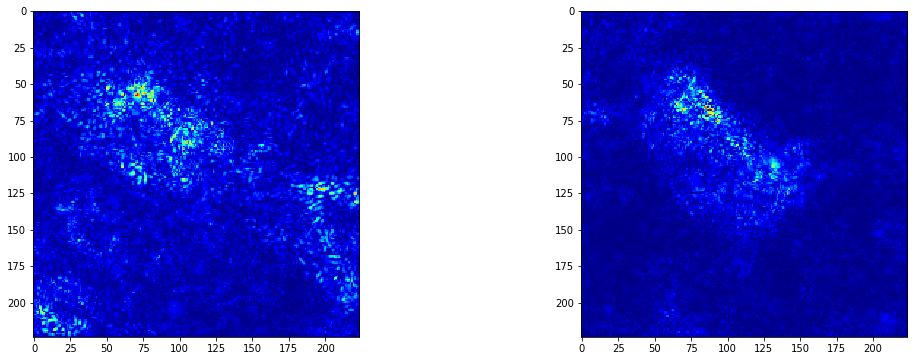

In [11]:
from vis.visualization import visualize_saliency, overlay
from vis.utils import utils
from keras import activations

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'predictions')

f, ax = plt.subplots(1, 2)
for i, img in enumerate([img1, img2]):    
    # 20 is the imagenet index corresponding to `ouzel`
    grads = visualize_saliency(model, layer_idx, filter_indices=index[i], seed_input=img)
    
    # visualize grads as heatmap
    ax[i].imshow(grads, cmap='jet')

Not that great. Very noisy. Lets try guided and rectified saliency.

To use guided saliency, we need to set `backprop_modifier='guided'`. For rectified saliency or deconv saliency, use `backprop_modifier='relu'`.

<Figure size 1296x432 with 0 Axes>

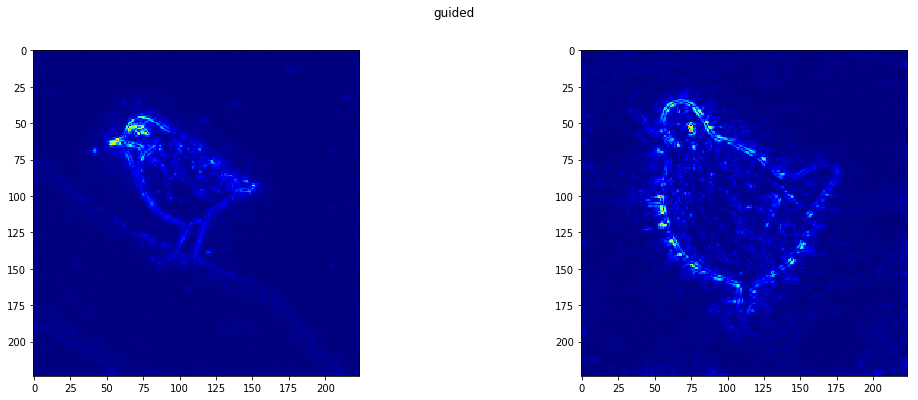

<Figure size 1296x432 with 0 Axes>

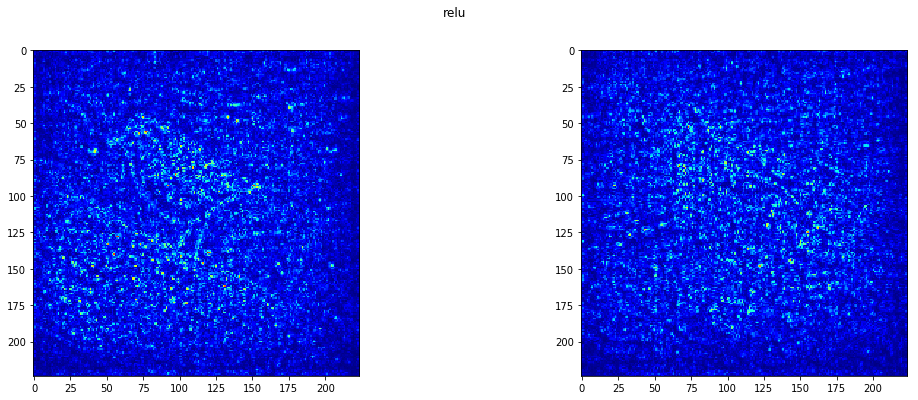

In [13]:
for modifier in ['guided', 'relu']:
    plt.figure()
    f, ax = plt.subplots(1, 2)
    plt.suptitle(modifier)
    for i, img in enumerate([img1, img2]):    
        # 20 is the imagenet index corresponding to `ouzel`
        grads = visualize_saliency(model, layer_idx, filter_indices=index[i], 
                                   seed_input=img, backprop_modifier=modifier)
        # Lets overlay the heatmap onto original image.    
        ax[i].imshow(grads, cmap='jet')

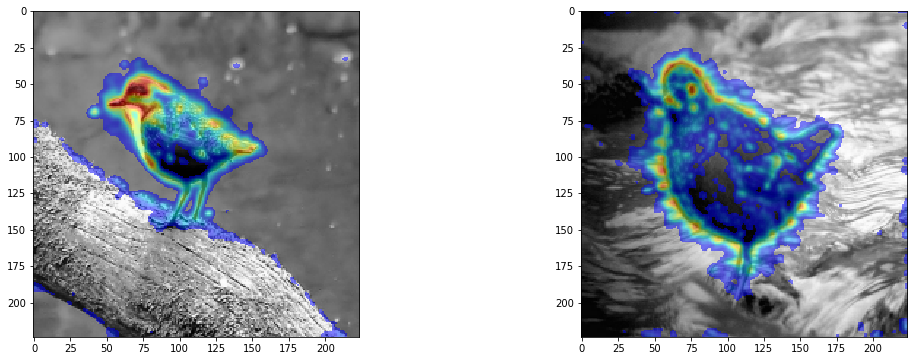

In [23]:
  import cv2
  import matplotlib.cm as cm
  from PIL import Image

  quantile=0.99
  threshold =0.1
  alpha=0.5
  
  f, ax = plt.subplots(1, 2)
  for i, img in enumerate([img1, img2]):  
    viz = visualize_saliency(model, layer_idx, filter_indices=index[i], 
                                 seed_input=img, backprop_modifier='guided')
    viz = np.clip(viz,None,np.quantile(viz, quantile))
    viz = (viz-np.min(viz))/(np.max(viz)-np.min(viz)+1e-7)
    viz = cv2.GaussianBlur(viz, (9,9), 0)

    jet_heatmap = cm.jet(viz)[..., :3]
    mask = viz[..., np.newaxis]>=threshold

    img = np.mean(img, axis=-1, keepdims=True)/255
    ax[i].imshow((alpha*jet_heatmap+(1-alpha)*img)*mask+img*(1-mask))


guided saliency is definitely better. I am not sure whats going on with rectified saliency.

## grad-CAM - vanilla, guided, rectified

These should contain more detail since they use `Conv` or `Pooling` features that contain more spatial detail which is lost in `Dense` layers. The only additional detail compared to saliency is the `penultimate_layer_idx`. This specifies the pre-layer whose gradients should be used. See this paper for technical details: https://arxiv.org/pdf/1610.02391v1.pdf

By default, if `penultimate_layer_idx` is not defined, it searches for the nearest pre layer. For our architecture, that would be the `block5_pool` layer after all the `Conv` layers. Here is the model summary for reference.

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

<Figure size 1296x432 with 0 Axes>

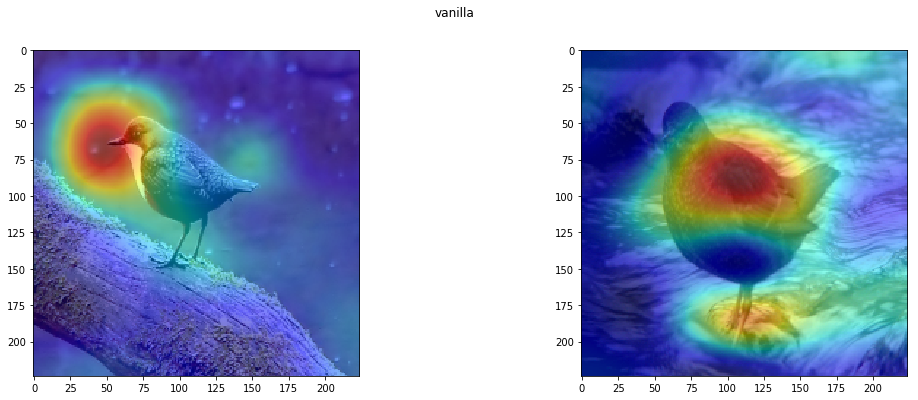

<Figure size 1296x432 with 0 Axes>

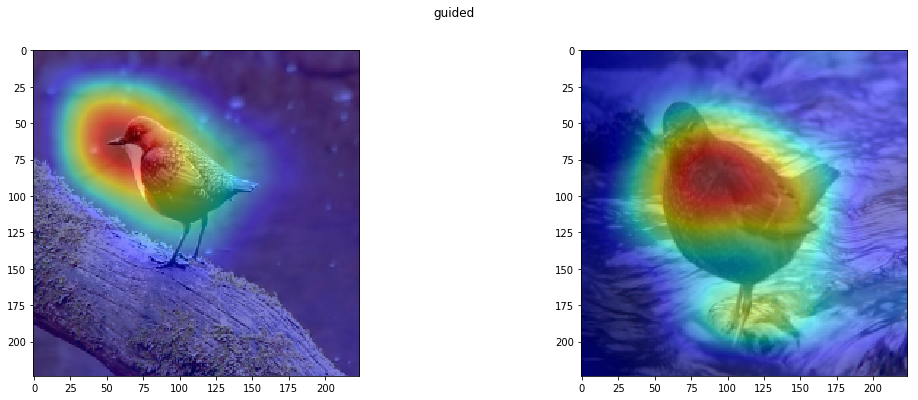

<Figure size 1296x432 with 0 Axes>

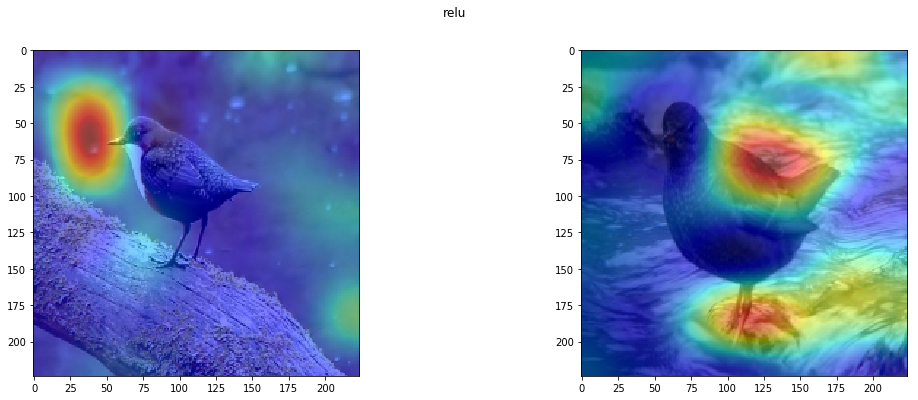

In [24]:
import numpy as np
import matplotlib.cm as cm
from vis.visualization import visualize_cam

for modifier in [None, 'guided', 'relu']:
    plt.figure()
    f, ax = plt.subplots(1, 2)
    plt.suptitle("vanilla" if modifier is None else modifier)
    for i, img in enumerate([img1, img2]):    
        # 20 is the imagenet index corresponding to `ouzel`
        grads = visualize_cam(model, layer_idx, filter_indices=index[i], 
                              seed_input=img, backprop_modifier=modifier)        
        # Lets overlay the heatmap onto original image.    
        jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
        ax[i].imshow(overlay(jet_heatmap, img))

guided grad-CAM wins again. It far less noisy than other options. Note: in the literature "guided grad-CAM usually means something else i.e. grad-CAM multiplied by  guided backprop"